# 67818 Applied Competitive Lab in Data Science

## Final Project

### Participants:

- **Name:** Dan Badur
- **Student ID:** 209019256
- 
- **Name:** Tzur Breen
- **Student ID:** 209354919
- 
- **Name:** Shir Elbilia
- **Student ID:** 208621102
- 
- **Name:** Eliya Hasson
- **Student ID:** 208845032
- 
- **Name:** Tal Barda
- **Student ID:** 208729210

#### 1. Data Preparation and Feature Engineering:

We will start by loading data.csv into a pandas dataframe and then we will start by cleaning the data and removing any unnecessary columns.

In [14]:
import sns
from sklearn.neighbors import BallTree
import geopandas as gpd
import numpy as np
import concurrent.futures
import math
from distance_calculations import calculate_distances_chunk
from distance_calculations import find_nearest_area_codes
import os
import sqlite3
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import OneHotEncoder


data_df = pd.read_csv("data.csv")
data_df = data_df.drop(columns=[
    'Unnamed: 0',
    'OBJECTID',
    'FOD_ID',
    'FPA_ID',
    'SOURCE_SYSTEM_TYPE',
    'SOURCE_SYSTEM',
    'NWCG_REPORTING_UNIT_ID',
    'NWCG_REPORTING_UNIT_NAME',
    'SOURCE_REPORTING_UNIT', 
    'SOURCE_REPORTING_UNIT_NAME',
    'LOCAL_FIRE_REPORT_ID',
    'LOCAL_INCIDENT_ID',
    'FIRE_CODE',
    'FIRE_NAME',
    'ICS_209_INCIDENT_NUMBER',
    'ICS_209_NAME', 
    'MTBS_ID',
    'MTBS_FIRE_NAME',
    'COMPLEX_NAME',
    'OWNER_CODE',
    'OWNER_DESCR',
    'FIPS_CODE',
    'FIPS_NAME',
    'Shape',
    'COUNTY'
])

Now we will define a function for calculating the distance between each point in our database and a set of polygons in a wanted shapefile.
The function is set to run on multiple cors for better performance. 

For our original data containing 571000 rows for an 8 core CPU (the code utilizes 0.75 of the cores):
Calculating for the nature polygons takes about 3 minutes.
For the others it's about 30 seconds to 1 minute each.

In [15]:

total_cores = os.cpu_count()
cores_to_use = math.ceil(total_cores * 0.75)
num_cores = max(1, cores_to_use) 
WGS_84_GEO = "EPSG:4326"

def calculate_distances_gdf_to_polygon_parallel(points_gdf, polygons_gdf, target_name, attribute_name=None):

    num_chunks = num_cores * 4  
    points_chunks = np.array_split(points_gdf, num_chunks)  
    polygons_sindex = polygons_gdf.sindex
    
    with tqdm(total=len(points_chunks), desc="Processing chunks for "+target_name) as pbar:
        with concurrent.futures.ProcessPoolExecutor(max_workers=num_cores) as executor:
            futures = [executor.submit(calculate_distances_chunk, chunk.geometry, polygons_gdf, polygons_sindex,return_attribute=attribute_name) for chunk in points_chunks]
            
            results = []
            for future in concurrent.futures.as_completed(futures):
                results.extend(future.result())
                pbar.update(1)
    
    return results

data_gdf = gpd.GeoDataFrame(data_df, geometry=gpd.points_from_xy(data_df.LONGITUDE, data_df.LATITUDE), crs=WGS_84_GEO)

nature_gdf = gpd.read_file('Nature/Nature.shp')
powerline_gdf = gpd.read_file('Powerline/Powerline.shp')
camp_gdf = gpd.read_file('Campgrounds/Campgrounds.shp')
population_gdf = gpd.read_file('Population/Population.shp')
railroads_gdf = gpd.read_file('Railroads/Railroads.shp')
schools_gdf = gpd.read_file('PublicSchools/PublicSchools.shp')
temp_gdf = gpd.read_file('Temperature/temps_shape.shp')

nature_gdf = nature_gdf.to_crs(WGS_84_GEO)
powerline_gdf = powerline_gdf.to_crs(WGS_84_GEO)
camp_gdf = camp_gdf.to_crs(WGS_84_GEO)
population_gdf = population_gdf.to_crs(WGS_84_GEO)
railroads_gdf = railroads_gdf.to_crs(WGS_84_GEO)
schools_gdf = schools_gdf.to_crs(WGS_84_GEO)
temp_gdf = temp_gdf.to_crs(WGS_84_GEO)

#Distance related features
data_df['distance_to_nearest_nature_km'] = calculate_distances_gdf_to_polygon_parallel(data_gdf, nature_gdf, "Nature")
data_df['distance_to_nearest_powerline_km'] = calculate_distances_gdf_to_polygon_parallel(data_gdf, powerline_gdf, "Powerline")
data_df['distance_to_nearest_campground_km'] = calculate_distances_gdf_to_polygon_parallel(data_gdf, camp_gdf, "Campground")
data_df['distance_to_nearest_railroad_km'] = calculate_distances_gdf_to_polygon_parallel(data_gdf, railroads_gdf, "Railroad")
data_df['distance_to_nearest_school_km'] = calculate_distances_gdf_to_polygon_parallel(data_gdf, schools_gdf, "School")

distance_from_population_and_class = calculate_distances_gdf_to_polygon_parallel(data_gdf, population_gdf, "Population", "POP_CLASS")
data_df['distance_to_nearest_population'], data_df['nearest_population_class'] = zip(*distance_from_population_and_class)


data_df = (data_df.drop( columns=['LONGITUDE', 'LATITUDE']))

/Users/talbarda/Desktop/FinalProject/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/talbarda/Desktop/FinalProject/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/talbarda/Desktop/FinalProject/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/talbarda/Desktop/FinalProject/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future vers

For calculating the temperature related features we will use the BallTree algorithm to find the nearest temperature area codes for each fire.
Then we will find the nearest dates (or the date itself)s for each fire and use them to fetch the weather data from an SQLite database we created from the temperature data.

For unknown average temp we will use the average monthly temperature for the state and month of the fire.
For the rest of the unknown values we will use the mean of the column.

Fetching the weather data from the SQLite database takes about 20 minutes.


In [16]:
import os

temps_dfs_path = 'temps_dfs'
data_dict = {}
state_dict = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'DC': 'District of Columbia',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming'
}


for year_dir in os.listdir(temps_dfs_path):
    year_path = os.path.join(temps_dfs_path, year_dir)
    
    if os.path.isdir(year_path):
        year_dict = {}
        
        for month_dir in os.listdir(year_path):
            month_path = os.path.join(year_path, month_dir)
            
            if os.path.isdir(month_path):
                days_list = [day.split('.')[0] for day in os.listdir(month_path) if day.endswith('.csv')]
                
                year_dict[int(month_dir)] = sorted(map(int, days_list))
        
        data_dict[int(year_dir)] = year_dict

coords_shapefile = np.array(list(temp_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
tree = BallTree(coords_shapefile, leaf_size=2)

tqdm.pandas(desc="Finding nearest temperature area codes")

column_nearest_area_codes = 'nearest_area_codes'
column_nearest_dates = 'nearest_dates'

data_df[column_nearest_area_codes] = data_gdf.progress_apply(find_nearest_area_codes, tree=tree, gdf_points=temp_gdf, axis=1)

column_discovery_date_temp = 'DISCOVERY_DATE_TEMP'
data_df[column_discovery_date_temp] = pd.to_datetime(data_df['DISCOVERY_DATE'], origin='julian', unit='D')
data_df['FIRE_YEAR'] = data_df[column_discovery_date_temp].dt.year
data_df['Month'] = data_df[column_discovery_date_temp].dt.month
data_df['Day'] = data_df[column_discovery_date_temp].dt.day

def get_nearest_dates(row):
    year = row['FIRE_YEAR']
    month = row['Month']
    day = row['Day']
    nearest_dates = []
    
    if year in data_dict:
        if month in data_dict[year]:
            nearest_month = month
        else:
            nearest_month = min(data_dict[year].keys(), key=lambda x: abs(x - month))
        
        nearest_days = sorted(data_dict[year][nearest_month], key=lambda x: abs(x - day))[:10]
        
        for nearest_day in nearest_days:
            nearest_dates.append(f"{year}/{nearest_month:02d}/{nearest_day:02d}")
    
    return nearest_dates

tqdm.pandas(desc="Finding nearest dates for each fire data")
data_df[column_nearest_dates] = data_df.progress_apply(get_nearest_dates, axis=1)

conn_area_codes = sqlite3.connect('temps_area_code_dates.db')
conn_monthly = sqlite3.connect('average_monthly_temperature_by_state_1950-2022.db')

def get_monthly_mean(row):
    query = f'''
        SELECT average_temp
        FROM monthly_data
        WHERE year = {row['FIRE_YEAR']} AND month = {row['Month']} AND state = '{state_dict[row['STATE']]}'
        LIMIT 1
    '''
    cursor = conn_monthly.cursor()
    cursor.execute(query)
    result = cursor.fetchone()
    cursor.close()
    return result[0] if result else None


def get_weather_data(row):
    nearest_dates = row[column_nearest_dates]  # Get the nearest dates list
    area_codes = [int(x) for x in row[column_nearest_area_codes]]

    max_temp, min_temp, prcp, avg_temp = None, None, None, None
    
    for nearest_date in nearest_dates:
        for area_code in area_codes:
            query = f'''
                SELECT max_temp, min_temp, prcp, avg_temp
                FROM weather_data
                WHERE YEAR = {nearest_date.split('/')[0]}
                AND MONTH = {nearest_date.split('/')[1]}
                AND DAY = {nearest_date.split('/')[2]}
                AND area_code = {area_code}
                LIMIT 1
            '''

            cursor = conn_area_codes.cursor()
            cursor.execute(query)
            result = cursor.fetchone()
            cursor.close()

            if result:
                max_temp = result[0] if max_temp is None and result[0] is not None else max_temp
                min_temp = result[1] if min_temp is None and result[1] is not None else min_temp
                prcp = result[2] if prcp is None and result[2] is not None else prcp
                avg_temp = result[3] if avg_temp is None and result[3] is not None else avg_temp
                
                if all([max_temp, min_temp, prcp, avg_temp]):
                    break

        if all([max_temp, min_temp, prcp, avg_temp]):
            break
    
    if min_temp is None or max_temp is None or avg_temp is None:
        monthly_mean = get_monthly_mean(row)
        if monthly_mean is not None:
            if avg_temp is None:
                avg_temp = monthly_mean

    return max_temp, min_temp, prcp, avg_temp


progress_bar = tqdm(total=len(data_df), desc="Fetching weather data from SQLite Database")

for index, row in data_df.iterrows():
    max_temp, min_temp, prcp, avg_temp = get_weather_data(row)
    progress_bar.update(1)  # Update progress for each row fetched
    
    data_df.at[index, 'MAX_TEMP'] = max_temp
    data_df.at[index, 'MIN_TEMP'] = min_temp
    data_df.at[index, 'PRCP'] = prcp
    data_df.at[index, 'AVG_TEMP'] = avg_temp

conn_area_codes.close()
conn_monthly.close()

#Remove the columns we used for the calculations
data_df = \
    (data_df.drop( 
        columns=[
            column_nearest_area_codes,
            column_nearest_dates,
            'STATE',
            column_discovery_date_temp]))


Finding nearest temperature area codes: 100%|██████████| 571425/571425 [01:16<00:00, 7459.46it/s]

Finding nearest dates for each fire data: 100%|██████████| 571425/571425 [00:08<00:00, 68316.12it/s]

Fetching weather data from SQLite Database: 100%|██████████| 571425/571425 [2:20:28<00:00, 67.79it/s]

Fetching weather data from SQLite Database: 100%|█████████▉| 571397/571425 [44:25<00:00, 719.83it/s]

Next we will explore time related features.

We worked on adding and exploring features related to time. We decided to check whether there is a connection between holidays and the type of the cause of the fire. The rational was that during holidays and vacations, people are returning home and may have more time to travel (campfire) or they just get bored and do some stupid things (children, arson...). Therefore, we downloaded a dataset that contains the dates of some holidays in the USA and added to our dataset the distance of every fire from the closest holiday in days. The added features are "nearest_holiday", "days_from_closest_holiday".

In [17]:
from datetime import datetime, timedelta

holiday_dates_df = pd.read_csv(f"US Holiday Dates (1992-2015).csv")

# Convert 'Date' in holiday_dates_df to datetime objects
holiday_dates_df['Date'] = pd.to_datetime(holiday_dates_df['Date'], dayfirst=True, format="%d/%m/%Y")

# Create a dictionary to map each year to its holidays
holiday_dict = {}
for year in holiday_dates_df['Year'].unique():
    holiday_dict[year] = holiday_dates_df[holiday_dates_df['Year'] == year]

def find_nearest_holiday(fire_year, discovery_doy):
    if fire_year not in holiday_dict:
        return ("No Data", "No Data")
    year_holidays = holiday_dict[fire_year]
    fire_date = datetime(fire_year, 1, 1) + timedelta(days=discovery_doy - 1)
    nearest_holiday = None
    min_days_diff = float('inf')
    for _, row in year_holidays.iterrows():
        holiday_date = row['Date']
        diff = abs((fire_date - holiday_date).days)
        if diff < min_days_diff:
            min_days_diff = diff
            nearest_holiday = row['Holiday']
    return (nearest_holiday, min_days_diff)

tqdm.pandas(desc="Finding nearest holiday for each fire")
data_df['nearest_holiday'], data_df['days_from_closest_holiday'] = zip(*data_df.progress_apply(lambda row: find_nearest_holiday(row['FIRE_YEAR'], row['DISCOVERY_DOY']), axis=1))

#encoding the holiday feature
ohe = OneHotEncoder(sparse_output=False)
encoded_holiday = ohe.fit_transform(data_df[['nearest_holiday']])
data_df = pd.concat([data_df.drop(columns=['nearest_holiday']), pd.DataFrame(encoded_holiday, columns=ohe.get_feature_names_out())], axis=1)


Finding nearest holiday for each fire: 100%|██████████| 571425/571425 [03:55<00:00, 2425.73it/s]t/s]


We will also add here a season feature that will help predict the cause type:

In [18]:

def get_season(month):
    if month in [3, 4, 5]:
        return 0
    elif month in [6, 7, 8]:
        return 1
    elif month in [9, 10, 11]:
        return 2
    else:
        return 3
    
data_df['Season'] = data_df['Month'].apply(get_season)

We continue by making a new feature to check for the time it took to contain the fire using the DISCOVERY_DATE, DISCOVERY_TIME, CONT_DATE and CONT_TIME, for unknown CONT_TIME we will take the mean of the newly made TIME_TO_CONT_MINUTES feature (will be calculated using only train set to avoid data leakage)

In [19]:

def convert_datetime(df, date_column, time_column, datetime_column):
    df[date_column] = pd.to_datetime(df[date_column], unit='D', origin='julian')
    
    mask = df[time_column].notna()  # Create a mask to identify non-NA values
    hours = df.loc[mask, time_column] // 100
    minutes = df.loc[mask, time_column] % 100
    
    time_timedelta = pd.to_timedelta(hours, unit='h') + pd.to_timedelta(minutes, unit='m')
    
    df.loc[mask, datetime_column] = df.loc[mask, date_column] + time_timedelta
    
convert_datetime(data_df, 'DISCOVERY_DATE', 'DISCOVERY_TIME', 'DISCOVERY_DATETIME')
convert_datetime(data_df, 'CONT_DATE', 'CONT_TIME', 'CONT_DATETIME')

data_df['TIME_TO_CONT_MINUTES'] = (data_df['CONT_DATETIME'] - data_df['DISCOVERY_DATETIME']).dt.total_seconds() / 60
data_df.drop(["CONT_DATETIME", "DISCOVERY_DATETIME"], axis=1, inplace=True)

Next, we continue by encoding the categorical feature "NWCG_REPORTING_AGENCY" to one-hot encoding. We chose to encode this feature using one-hot encoding since we have a large number of agencies while some of them have sparse samples of data.

In [20]:

ohe = OneHotEncoder(sparse_output=False)  
encoded_data = ohe.fit_transform(data_df[['NWCG_REPORTING_AGENCY']])

df_encoded = pd.concat([data_df.drop(columns=['NWCG_REPORTING_AGENCY']), pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out())], axis=1)

We will also encode FIRE_CLASS:

In [21]:
fire_class_ohe = OneHotEncoder(sparse_output=False)
fire_class_encoded = fire_class_ohe.fit_transform(df_encoded[['FIRE_SIZE_CLASS']])
df_encoded = pd.concat([df_encoded.drop(columns=['FIRE_SIZE_CLASS']), pd.DataFrame(fire_class_encoded, columns=fire_class_ohe.get_feature_names_out())], axis=1)

In [22]:

from sklearn.model_selection import train_test_split

# Remove the rest of the columns we don't need:
df_encoded = df_encoded.drop(
    columns=[
        'DISCOVERY_DATE',
        'DISCOVERY_TIME',
        'CONT_DATE',
        'CONT_DOY',
        'CONT_TIME',
        'FIRE_YEAR',
        'Month', 
        'Day', 
        ])


# Change the target column to the last column:
target_column = df_encoded.pop('STAT_CAUSE_DESCR')
df_encoded['STAT_CAUSE_DESCR'] = target_column

# Make the target column integer:
category_mapping = df_encoded['STAT_CAUSE_DESCR'].astype('category')
mapping_dict = dict(enumerate(category_mapping.cat.categories))
df_encoded['STAT_CAUSE_DESCR'] = category_mapping.cat.codes

train_df, test_df = train_test_split(df_encoded, test_size=0.2, random_state=42)

#calculate the mean of none values in the train set:
mean_time_to_cont = train_df['TIME_TO_CONT_MINUTES'].mean()
mean_max_temp = train_df['MAX_TEMP'].mean()
mean_min_temp = train_df['MIN_TEMP'].mean()
mean_prcp = train_df['PRCP'].mean()
mean_avg_temp = train_df['AVG_TEMP'].mean()
mean_fire_size = train_df['FIRE_SIZE'].mean()

#apply to train and test:
train_df['TIME_TO_CONT_MINUTES'] = train_df['TIME_TO_CONT_MINUTES'].fillna(mean_time_to_cont)
train_df['MAX_TEMP'] = train_df['MAX_TEMP'].fillna(mean_max_temp)
train_df['MIN_TEMP'] = train_df['MIN_TEMP'].fillna(mean_min_temp)
train_df['PRCP'] = train_df['PRCP'].fillna(mean_min_temp)
train_df['AVG_TEMP']= train_df['AVG_TEMP'].fillna(mean_avg_temp)
train_df['FIRE_SIZE'] = train_df['FIRE_SIZE'].fillna(mean_fire_size)

test_df['TIME_TO_CONT_MINUTES'] = test_df['TIME_TO_CONT_MINUTES'].fillna(mean_time_to_cont)
test_df['MAX_TEMP'] = test_df['MAX_TEMP'].fillna(mean_max_temp)
test_df['MIN_TEMP'] = test_df['MIN_TEMP'].fillna(mean_min_temp)
test_df['PRCP'] = test_df['PRCP'].fillna(mean_prcp)
test_df['AVG_TEMP']= test_df['AVG_TEMP'].fillna(mean_avg_temp)
test_df['FIRE_SIZE'] = test_df['FIRE_SIZE'].fillna(mean_fire_size)

Now we will train Gradeint Boosting Classifier and Random Forest Classifier models and evaluate them using the test set via ROC AUC score.

In [23]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


df_encoded = df_encoded.drop(columns=df_encoded.columns[df_encoded.columns.str.startswith('NWGC')])
df_encoded = df_encoded.drop(columns=df_encoded.columns[df_encoded.columns.str.startswith('nearest_holiday')])

# Assuming train_df and test_df are defined elsewhere and contain the necessary data
X_train = train_df.drop(columns=['STAT_CAUSE_DESCR'])
y_train = train_df['STAT_CAUSE_DESCR']

X_test = test_df.drop(columns=['STAT_CAUSE_DESCR'])
y_test = test_df['STAT_CAUSE_DESCR']

# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42, verbose=1)
gbc.fit(X_train, y_train)
# Predict class probabilities for ROC AUC score calculation
gbc_prob = gbc.predict_proba(X_test)
# Calculate ROC AUC score for multi-class using One-vs-Rest (OvR) approach
gbc_score = roc_auc_score(y_test, gbc_prob, multi_class='ovr')

# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1)
rfc.fit(X_train, y_train)
# Predict class probabilities for ROC AUC score calculation
rfc_prob = rfc.predict_proba(X_test)
# Calculate ROC AUC score for multi-class using One-vs-Rest (OvR) approach
rfc_score = roc_auc_score(y_test, rfc_prob, multi_class='ovr')

print(f"Gradient Boosting Classifier ROC AUC score: {gbc_score:.2f}")
print(f"Random Forest Classifier ROC AUC score: {rfc_score:.2f}")

      Iter       Train Loss   Remaining Time 
         1           1.9546           10.18m
         2           1.9265           10.03m
         3           1.9048            9.92m
         4           1.8857            9.81m
         5           1.8695            9.70m
         6           1.8553            9.59m
         7           1.8429            9.49m
         8           1.8328            9.39m
         9           1.8238            9.29m
        10           1.8150            9.19m
        20           1.7532            8.16m
        30           1.7181            7.14m
        40           1.6954            6.12m
        50           1.6774            5.10m
        60           1.6638            4.08m
        70           1.6528            3.06m
        80           1.6439            2.04m
        90           1.6372            1.02m
       100           1.6311            0.00s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   58.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.6s


Gradient Boosting Classifier ROC AUC score: 0.76
Random Forest Classifier ROC AUC score: 0.77


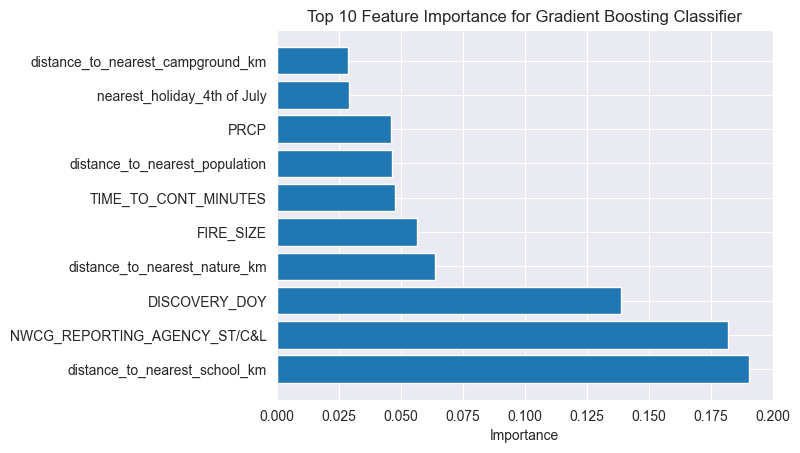

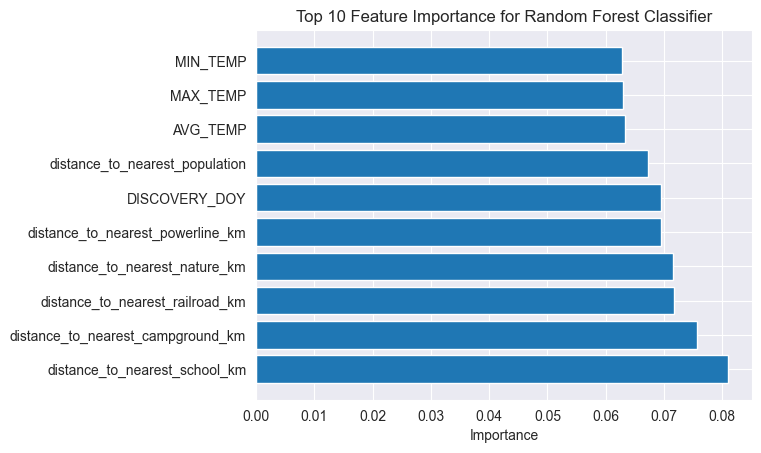

In [24]:
#Feature importance for both models

# Gradient Boosting Classifier
gbc_feature_importance = gbc.feature_importances_
gbc_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': gbc_feature_importance})
gbc_feature_importance_df = gbc_feature_importance_df.sort_values(by='Importance', ascending=False)

#Plot the feature importance
fig, ax = plt.subplots()
ax.barh(gbc_feature_importance_df['Feature'][:10], gbc_feature_importance_df['Importance'][:10])
ax.set_xlabel('Importance')
ax.set_title('Top 10 Feature Importance for Gradient Boosting Classifier')
plt.show()


# Random Forest Classifier
rfc_feature_importance = rfc.feature_importances_
rfc_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': rfc_feature_importance})
rfc_feature_importance_df = rfc_feature_importance_df.sort_values(by='Importance', ascending=False)

#Plot the feature importance א
fig, ax = plt.subplots()
ax.barh(rfc_feature_importance_df['Feature'][:10], rfc_feature_importance_df['Importance'][:10])
ax.set_xlabel('Importance')
ax.set_title('Top 10 Feature Importance for Random Forest Classifier')
plt.show() 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.2s


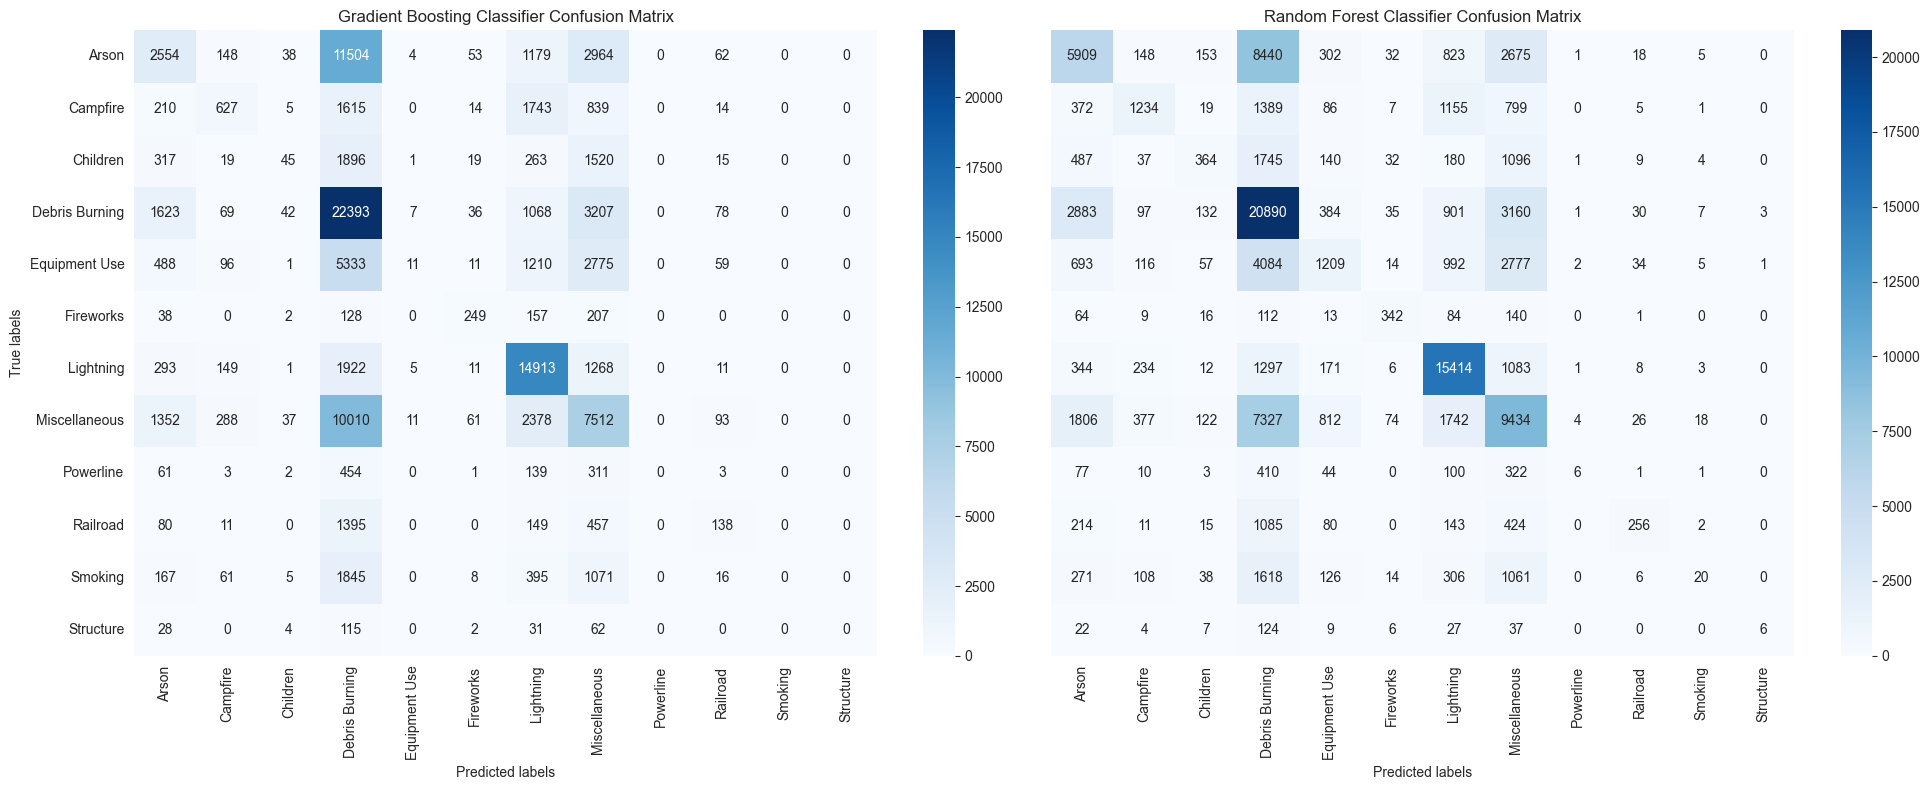

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming `gbc` and `rfc` are your trained models
# Assuming `X_test` and `y_test` are your test datasets
# Assuming `mapping_dict` is your mapping from integer labels back to string labels

# Generate predictions
gbc_predictions = gbc.predict(X_test)
rfc_predictions = rfc.predict(X_test)

# Convert integer predictions back to string labels using the mapping dictionary
gbc_predictions_strings = [mapping_dict[label] for label in gbc_predictions]
rfc_predictions_strings = [mapping_dict[label] for label in rfc_predictions]
y_test_strings = [mapping_dict[label] for label in y_test]  # Convert y_test to strings

# Compute confusion matrices with string labels
labels_list = list(mapping_dict.values())  # Get the list of original string labels
gbc_cm = confusion_matrix(y_test_strings, gbc_predictions_strings, labels=labels_list)
rfc_cm = confusion_matrix(y_test_strings, rfc_predictions_strings, labels=labels_list)

# Visualize the confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Gradient Boosting Classifier Confusion Matrix
sns.heatmap(gbc_cm, annot=True, fmt="d", ax=ax[0], cmap='Blues', xticklabels=labels_list, yticklabels=labels_list)
ax[0].set_title('Gradient Boosting Classifier Confusion Matrix')
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')

# Random Forest Classifier Confusion Matrix
sns.heatmap(rfc_cm, annot=True, fmt="d", ax=ax[1], cmap='Blues', xticklabels=labels_list, yticklabels=labels_list)
ax[1].set_title('Random Forest Classifier Confusion Matrix')
ax[1].set_xlabel('Predicted labels')
# ax[1].set_ylabel('True labels')  # Optional, already set for ax[0] and shared Y axis

plt.tight_layout()
plt.show()



In [26]:
import numpy as np

# Function to calculate and print accuracy for each class
def print_class_accuracy(confusion_matrix, class_labels):
    print("Class-wise Accuracy:")
    for i, label in enumerate(class_labels):
        true_positives = confusion_matrix[i, i]
        total_instances = np.sum(confusion_matrix[i, :])
        if total_instances > 0:
            accuracy = true_positives / total_instances
            print(f"{label}: {accuracy:.2f}")
        else:
            print(f"{label}: No instances in the test set.")

# Assuming gbc_cm and rfc_cm are your confusion matrices from the previous step
# Assuming labels_list contains your class labels as strings

print("Gradient Boosting Classifier")
print_class_accuracy(gbc_cm, labels_list)
print("\nRandom Forest Classifier")
print_class_accuracy(rfc_cm, labels_list)


Gradient Boosting Classifier
Class-wise Accuracy:
Arson: 0.14
Campfire: 0.12
Children: 0.01
Debris Burning: 0.79
Equipment Use: 0.00
Fireworks: 0.32
Lightning: 0.80
Miscellaneous: 0.35
Powerline: 0.00
Railroad: 0.06
Smoking: 0.00
Structure: 0.00

Random Forest Classifier
Class-wise Accuracy:
Arson: 0.32
Campfire: 0.24
Children: 0.09
Debris Burning: 0.73
Equipment Use: 0.12
Fireworks: 0.44
Lightning: 0.83
Miscellaneous: 0.43
Powerline: 0.01
Railroad: 0.11
Smoking: 0.01
Structure: 0.02
